In [1]:
import pandas as pd
import numpy as np
from sklearn import preprocessing
from sklearn.ensemble import RandomForestRegressor
from scipy.stats import norm
import GPy
import GPyOpt
import math, os, random, copy, time, itertools, gc, time, warnings

import numpy as np
import torch
import math
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import GPyOpt
import GPy
import os
import matplotlib as mpl
import matplotlib.tri as tri
import ternary
import pickle
import datetime
from collections import Counter
import matplotlib.ticker as ticker
import pyDOE
import random
from sklearn import preprocessing
from scipy.stats import norm
from sklearn.ensemble import RandomForestRegressor
import matplotlib.font_manager as font_manager
import copy
from scipy.interpolate import splrep
from scipy.interpolate import interp1d
import secrets

In [2]:
PATH = os.getcwd()
PATH = PATH.split(os.path.sep)
if "src" in PATH:
    PATH.remove("src")
PATH = os.path.sep.join(PATH)

random.seed(5853)
NUM_MODELS = 50
SEED_LIST = [random.randint(0, 9999) for _ in range(NUM_MODELS)]
DATASET = "AutoAM"

In [3]:
# Random Baseline
def P_rand(nn):
    x_random = np.arange(nn)
    
    M = 5 #fix me!!!
    N = nn
    
    P = np.array([None for i in x_random])
    E = np.array([None for i in x_random])
    A = np.array([None for i in x_random])
    cA = np.array([None for i in x_random])
    
    P[0] = M / N
    E[0] = M / N
    A[0] = M / N
    cA[0] = A[0]
    

    for i in x_random[1:]:
        P[i] = (M - E[i-1]) / (N - i)
        E[i] = np.sum(P[:(i+1)])
        j = 0
        A_i = P[i]
        while j < i:
            A_i *= (1 - P[j])
            j+=1
        A[i] = A_i
        cA[i] = np.sum(A[:(i+1)])
        
    return E / M, cA

In [4]:
def aggregation_(seed, n_runs, n_fold):
    assert math.fmod(n_runs, n_fold) == 0
    fold_size = int(n_runs / n_fold)
    random.seed(seed)
    index_runs = list(np.arange(n_runs))
    agg_list = []
    i = 0
    while i < n_fold:
        index_i = random.sample(index_runs, fold_size)
        for j in index_i:
            index_runs.remove(j)
        agg_list.append(index_i)
        i += 1
        return agg_list

def avg_(x):
    n_eval = len(x[0]) 
    n_fold = 5
    n_runs = len(x)
    assert math.fmod(n_runs, n_fold) == 0
    fold_size = int(n_runs / n_fold)
    n_sets = len(SEED_LIST)
    l_index_list = []
    for i in np.arange(n_sets):
        s = aggregation_(SEED_LIST[i], n_runs, n_fold)
        l_index_list.extend(s)

    #assert len(l_index_list) == n_sets * n_fold
    l_avg_runs = []
    for i in np.arange(len(l_index_list)):
        avg_run = np.zeros(n_eval)
        for j in l_index_list[i]:
            avg_run += x[j]
        avg_run = avg_run/fold_size
        l_avg_runs.append(avg_run)
    assert n_eval == len(l_avg_runs[0])
    #assert n_sets * n_fold == len(l_avg_runs)
    mean_ = [None for i in np.arange(n_eval)]
    std_ = [None for i in np.arange(n_eval)]
    median_ = [None for i in np.arange(n_eval)]
    low_q = [None for i in np.arange(n_eval)]
    high_q = [None for i in np.arange(n_eval)]
    for i in np.arange(len(l_avg_runs[0])):
        i_column = []
        for j in np.arange(len(l_avg_runs)):
            i_column.append(l_avg_runs[j][i])
        i_column = np.array(i_column)
        mean_[i] = np.mean(i_column)
        median_[i] = np.median(i_column)
        std_[i] = np.std(i_column)
        low_q[i] = np.quantile(i_column, 0.05, out=None, overwrite_input=False, interpolation='linear')
        high_q[i] = np.quantile(i_column, 0.95, out=None, overwrite_input=False, interpolation='linear')
    return np.array(median_), np.array(low_q), np.array(high_q), np.array(mean_), np.array(std_)

In [5]:
def TopPercent(x_top_count, n_top, N):
    x_ = [[] for _ in np.arange(len(x_top_count))]
    for i in np.arange(len(x_top_count)):
        for j in np.arange(N):
            if j < len(x_top_count[i]):
                x_[i].append(x_top_count[i][j] / n_top)
            else:
                x_[i].append(1)
    return x_

### Creating Graph

In [7]:
files = dict()
for file in os.listdir(os.path.join(PATH, "results")):
    if file == '.DS_Store':
        continue
    f = np.load(os.path.join(PATH, "results", file), allow_pickle=True)
    files[file[:-4]] = f

In [8]:
def df_preprocessing(data_name: str) -> pd.DataFrame:
    df = pd.read_csv(os.path.join(PATH, "datasets", data_name + "_dataset.csv"))
    # (A) There are multiple of the same experiments, so average them!
    features = list(df.columns)[:-1]
    obj_metric = list(df.columns)[-1]
    df = df.groupby(features)[obj_metric].agg(lambda x: x.unique().mean())
    df = (df.to_frame()).reset_index()
    # (B) Change all NECESSARY df to a minimization problem
    if data_name in ["P3HT", "Crossed barrel", "AutoAM"]:
        # aka AgNP & Perovskite
        df[obj_metric] = -df[obj_metric].values
    return df

df_AutoAM = df_preprocessing("AutoAM")

feature_name = list(df_AutoAM.columns)[:-1]
objective_name = list(df_AutoAM.columns)[-1]
N = len(df_AutoAM) # Number of datapoints
n_top = int(math.ceil(N * 0.05))
top_indices = list(df_AutoAM.sort_values(objective_name).head(n_top).index)

In [9]:
"""
FILES = [
    "GP_MLP_ARD_PI_AutoAM",
    "GP_Matern12_LCB_AutoAM",
    "GP_RBF_EI_AutoAM",
    "RF_LCB_AutoAM",
    "GP_Matern12_ARD_PI_AutoAM",
    "GP_MLP_ARD_LCB_AutoAM",
    "GP_Matern12_ARD_EI_AutoAM",
    "GP_RBF_LCB_AutoAM",
    "GP_MLP_ARD_EI_AutoAM",
    "GP_RBF_PI_AutoAM",
    "GP_Matern52_ARD_PI_AutoAM",
    "GP_RBF_ARD_PI_AutoAM",
    "GP_Matern52_LCB_AutoAM",
    "GP_Matern32_ARD_EI_AutoAM",
    "GP_Matern52_ARD_LCB_AutoAM",
    "GP_MLP_PI_AutoAM",
    "GP_Matern52_EI_AutoAM",
    "GP_Matern12_PI_AutoAM",
    "RF_EI_AutoAM",
    "GP_MLP_LCB_AutoAM",
    "GP_Matern32_ARD_LCB_AutoAM",
    "GP_Matern32_EI_AutoAM",
    "GP_Matern12_ARD_LCB_AutoAM",
    "GP_Matern12_EI_AutoAM",
    "RF_PI_AutoAM",
    "GP_Matern32_LCB_AutoAM",
    "GP_Matern32_PI_AutoAM",
    "GP_RBF_ARD_LCB_AutoAM",
    "GP_RBF_ARD_EI_AutoAM",
    "GP_Matern52_ARD_EI_AutoAM",
    "GP_MLP_EI_AutoAM",
    "GP_Matern32_ARD_PI_AutoAM",
    "GP_Matern52_PI_AutoAM",
    ]
"""
FILES = [
    "GP_MLP_ARD_PI_AutoAM",
    "GP_Matern12_LCB_AutoAM",
    "GP_RBF_EI_AutoAM",
    "RF_LCB_AutoAM",
    "GP_Matern12_ARD_PI_AutoAM",
    "GP_MLP_ARD_LCB_AutoAM",
    "GP_Matern12_ARD_EI_AutoAM",
    "GP_RBF_LCB_AutoAM",
    "GP_MLP_ARD_EI_AutoAM",
    "GP_RBF_PI_AutoAM",
    "GP_Matern52_ARD_PI_AutoAM",
    "GP_RBF_ARD_PI_AutoAM",
    "GP_Matern52_LCB_AutoAM",
    "GP_Matern32_ARD_EI_AutoAM",
    "GP_Matern52_ARD_LCB_AutoAM",
    "GP_MLP_PI_AutoAM",
    "GP_Matern52_EI_AutoAM",
    "GP_Matern12_PI_AutoAM",
    "RF_EI_AutoAM",
    "GP_MLP_LCB_AutoAM",
    "GP_Matern32_ARD_LCB_AutoAM",
    "GP_Matern32_EI_AutoAM",
    "GP_Matern12_ARD_LCB_AutoAM",
    "GP_Matern12_EI_AutoAM",
    "RF_PI_AutoAM",
    "GP_Matern32_LCB_AutoAM",
    "GP_Matern32_PI_AutoAM",
    "GP_RBF_ARD_LCB_AutoAM",
    "GP_RBF_ARD_EI_AutoAM",
    "GP_Matern52_ARD_EI_AutoAM",
    "GP_MLP_EI_AutoAM",
    "GP_Matern32_ARD_PI_AutoAM",
    "GP_Matern52_PI_AutoAM",
    ]

([<matplotlib.axis.YTick at 0x28c2aa550>,
 [Text(0, 0.0, '0'),
  Text(0, 0.2, '0.2'),
  Text(0, 0.4, '0.4'),
  Text(0, 0.6, '0.6'),
  Text(0, 0.8, '0.8'),
  Text(0, 1.0, '1.0')])

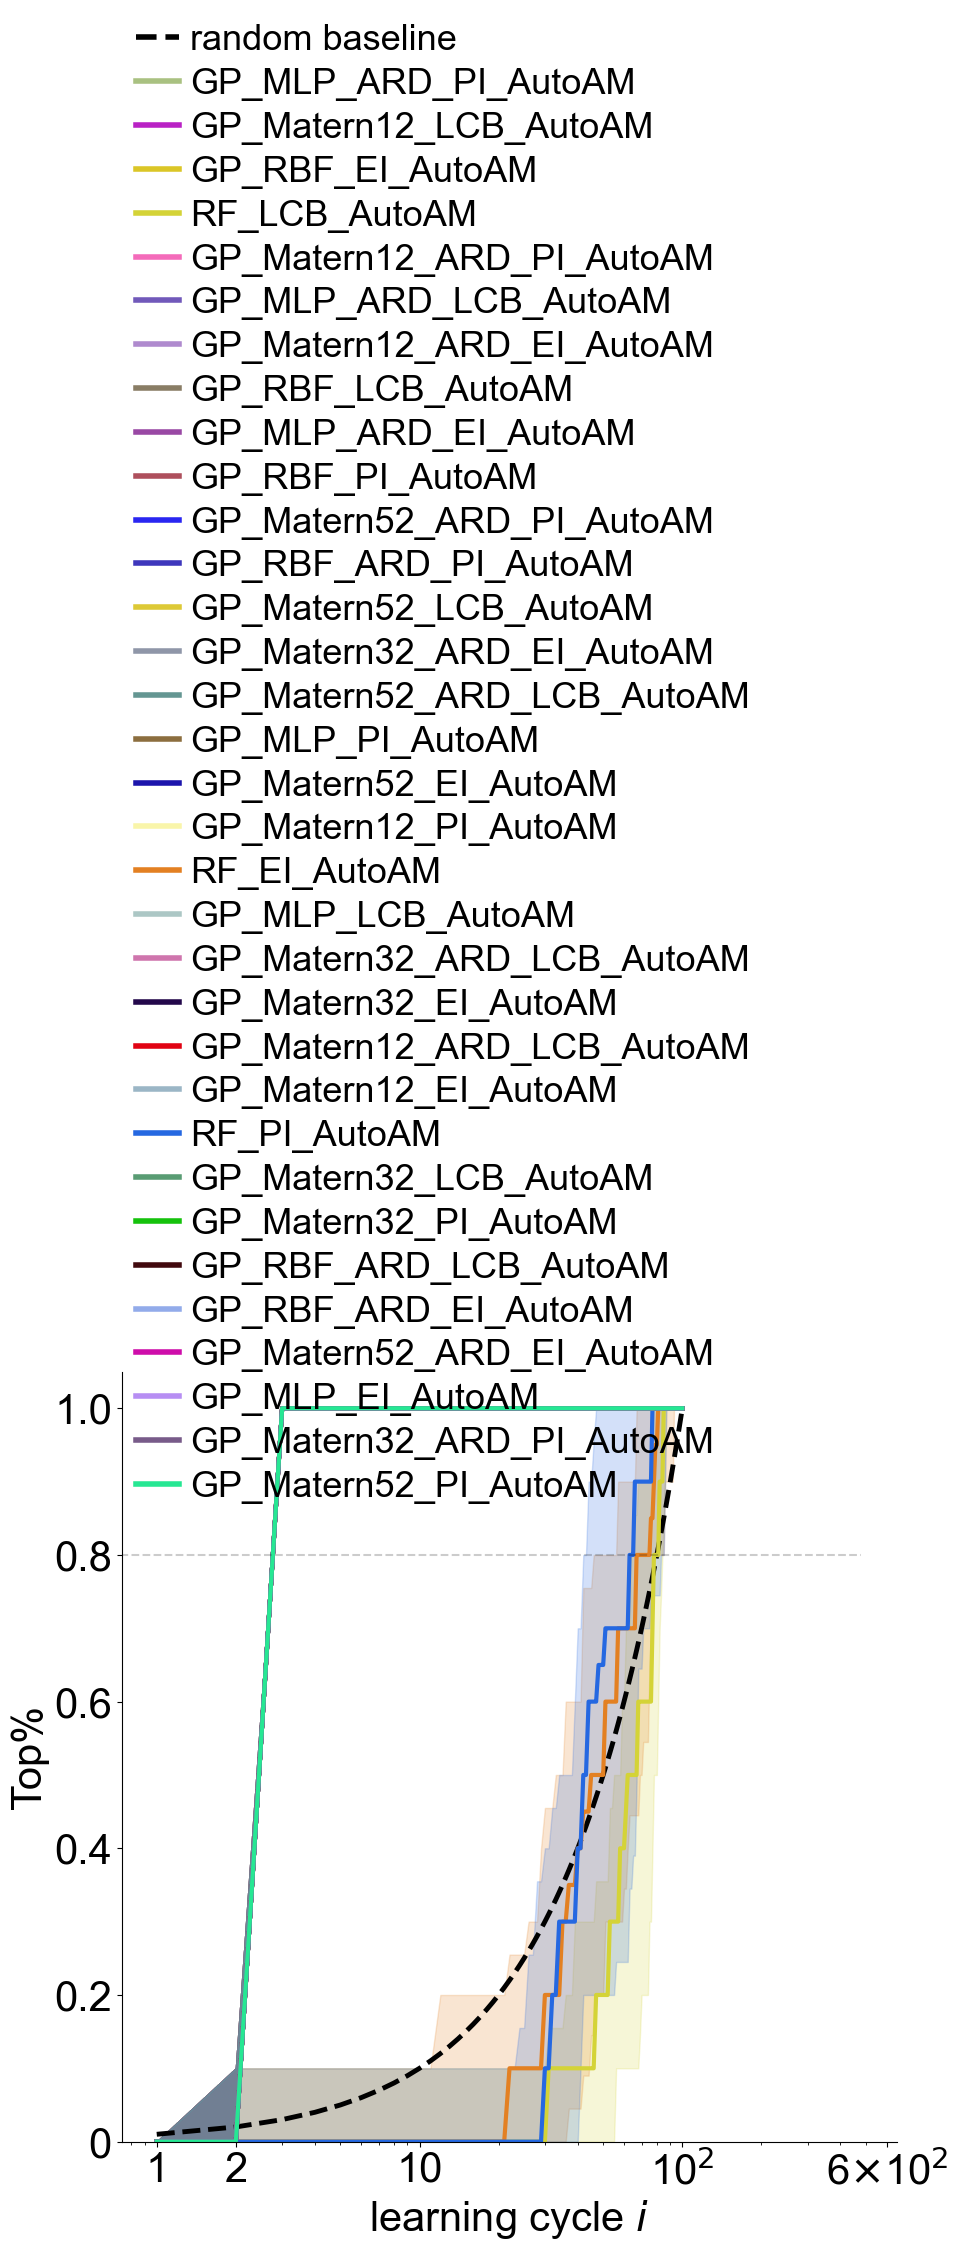

In [10]:
fig = plt.figure(figsize=(10,10))
ax0 = fig.add_subplot(111)
ax0.plot(np.arange(N)+1, P_rand(N)[0],'--',color='black',label='random baseline', linewidth=3.5)

for file in FILES:
    if not file in files.keys():
        continue
    f = files[file]
    f = f["TopCount_collection"]
    f = f.tolist()
    f_TopPercent = avg_(TopPercent(f, n_top, N))
    
    #color
    red = secrets.randbelow(256)
    green = secrets.randbelow(256)
    blue = secrets.randbelow(256)
    color_code = '#{:02x}{:02x}{:02x}'.format(red, green, blue)

    ax0.plot(np.arange(N) + 1,
             np.round(f_TopPercent[0].astype(np.double) / 0.005, 0) * 0.005,
             label = file, color = color_code, linewidth=3)
    ax0.fill_between(np.arange(N) + 1,
                     np.round(f_TopPercent[1].astype(np.double) / 0.005, 0) * 0.005,
                     np.round(f_TopPercent[2].astype(np.double) / 0.005, 0) * 0.005,
                     color = color_code, alpha=0.2)

# the rest are for visualization purposes, please adjust for different needs
font = font_manager.FontProperties(family='Arial', size = 26, style='normal')
leg = ax0.legend(prop = font, borderaxespad = 0,  labelspacing = 0.3, handlelength = 1.2, handletextpad = 0.3, frameon=False, loc = (0, 0.81))
for line in leg.get_lines():
    line.set_linewidth(4)
ax0.set_ylabel("Top%", fontname="Arial", fontsize=30, rotation='vertical')    
plt.hlines(0.8, 0, 480, colors='k', linestyles='--', alpha = 0.2)
ax0.set_ylim([0, 1.05])
ax0.set_xscale('log')
ax0.set_xlabel('learning cycle $i$', fontsize=30, fontname = 'Arial')
ax0.xaxis.set_tick_params(labelsize=30)
ax0.yaxis.set_tick_params(labelsize=30)
ax0.spines['right'].set_visible(False)
ax0.spines['top'].set_visible(False)
plt.xticks([1, 2, 10, 100, 600], ['1', '2','10', '10$^{\mathrm{2}}$', '6$×$10$^{\mathrm{2}}$'],fontname = 'Arial')
plt.yticks([0, 0.2, 0.4, 0.6, 0.8, 1.0], ['0', '0.2', '0.4', '0.6', '0.8', '1.0'], fontname = 'Arial')